## EuroSAT CNN Model

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
from torch.utils.data import random_split
import sys
import os
# Suppress download messages
old_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

# Downloading and loading full dataset
full_dataset = datasets.EuroSAT(root='./data', 
                                 download=True, 
                                 transform=transform)

sys.stdout = old_stdout

# Split into train/val/test (70/15/15)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Creating data loaders
train_loader = DataLoader(train_dataset, 
                          batch_size=64, 
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=64,
                        shuffle=False)

test_loader = DataLoader(test_dataset, 
                         batch_size=64, 
                         shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 18900
Validation samples: 4050
Test samples: 4050


In [5]:
image, label = train_dataset[0] # type: ignore

print(image.size())
print(f"Category label: {label}")

torch.Size([3, 64, 64])
Category label: 0


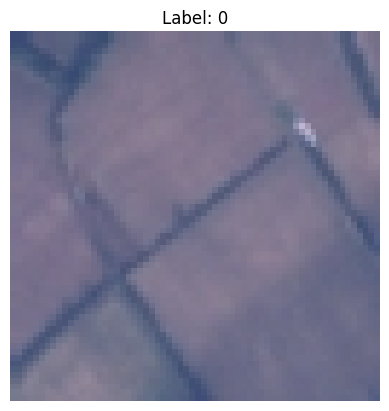

In [6]:
import matplotlib.pyplot as plt

img = image.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [7]:
classes = full_dataset.classes
print(classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=256 * 4 * 4, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)

        self.dropout = nn.Dropout(p=0.6)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [15]:
CNN_Model = CNNModel()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_Model.parameters(), lr=0.001)

In [16]:
# Test forward pass to see actual dimension
model = CNNModel()
x = torch.randn(1, 3, 64, 64)
x = model.pool(F.relu(model.conv1(x)))
x = model.pool(F.relu(model.conv2(x)))
x = model.pool(F.relu(model.conv3(x)))
x = model.pool(F.relu(model.conv4(x)))

print(x.shape)  # Will show you the actual dimensions
x = torch.flatten(x, 1)

print(x.shape)  # This is what fc1 should expect

torch.Size([1, 256, 4, 4])
torch.Size([1, 4096])


In [17]:
from torchinfo import summary
summary(CNN_Model, input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 64, 64]           896
├─MaxPool2d: 1-2                         [1, 32, 32, 32]           --
├─Conv2d: 1-3                            [1, 64, 32, 32]           18,496
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Conv2d: 1-5                            [1, 128, 16, 16]          73,856
├─MaxPool2d: 1-6                         [1, 128, 8, 8]            --
├─Conv2d: 1-7                            [1, 256, 8, 8]            295,168
├─MaxPool2d: 1-8                         [1, 256, 4, 4]            --
├─Linear: 1-9                            [1, 512]                  2,097,664
├─Dropout: 1-10                          [1, 512]                  --
├─Linear: 1-11                           [1, 10]                   5,130
Total params: 2,491,210
Trainable params: 2,491,210
Non-train

In [18]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [19]:
print(f"Current device: {next(CNN_Model.parameters()).device}")

device = torch.device('mps')
print(f"Using device: {device}")

CNN_Model = CNN_Model.to(device)
print(f"Current device: {next(CNN_Model.parameters()).device}")

Current device: cpu
Using device: mps
Current device: mps:0
